# Techniques for Improving Performance
In this notebook we will explore some strategies for improving the performance of our models, specifically with regards to generalization, but modifying features and using regularization.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso, Ridge
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Creating a dataset
For now we will look at another arbitrary dataset to explore some of the sources of bias and variance, as well as techniques that might alleviate these problems. 

Let's assume that there is some phenomena that has a ground truth function we would like to estimate that has the following form:

$$
f_\theta(x) = \theta_0 + \theta_1x + \theta_2x^2 + \theta_3x^3
$$

This is a polynomial regression. We only have access to one real feature, $x$, but we can artifically create additional features from this such as $x^2, x^3$ etc. The model is still linear because the response is a still a linear combination of its parameters. Alternatively you can think of substituting $x^2 = x_2, x^3 = x_3$.

I am arbitrarily choosing the true parameters to be $\theta_0 = 0, \theta_1 = 1, \theta_2 = 0, \theta_3 = 0.1$, such that the true function is given by:

$$
f_\theta(x) = 1x + 0.1x^3
$$

In reality there is an unavoidable error, $\epsilon$, for example it could be error from measurement noise. Obviously as engineers we should be quite familiar with this. 

$$
y_\theta(x) = f_\theta(x) + \epsilon
$$

In [14]:
# Create arbitrary truth function
theta_true = [0, 1, 0, 0.1]
X = np.linspace(-10, 10, 1000).reshape(-1, 1)
y = theta_true[0] + theta_true[1]*X + theta_true[2]*X**2 + theta_true[3]*X**3

# Real data will have noise
X_set = np.random.uniform(-10, 10, 100)
y_set = theta_true[0] + theta_true[1]*X_set + theta_true[2]*X_set**2 + theta_true[3]*X_set**3 + np.random.normal(0, 10, 100)


# Evaluting Generalization

By now it should be clear that we want to train models that generalize to unseen data. This is crucial for deploying models into real-world scenarios. The basic form of determining a model's ability to generalize is by providing two independant sets of data. One to use during learning (parameters are updated) and one to use during testing (parameters are fixed). Later we will observe alternative techniques that may provide better evaluations.

In [15]:
# Basic train, test split to evaluate models
X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, test_size=0.5, random_state=1)

# Visualising the Data

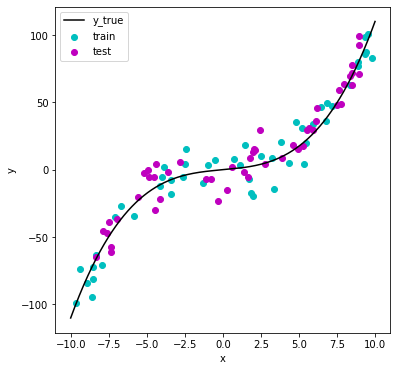

In [16]:
fig = plt.figure(figsize=(6,6))
plt.plot(X, y, color='k', label='y_true')
plt.scatter(X_train, y_train, color='c', label='train')
plt.scatter(X_test, y_test, color='m', label='test')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Simple Linear Regression
As a first attempt we might make the assumption that the true function can be approximated by a simple linear regression model. As a refresher this would take the form:

$$
h_\theta(x) = \theta_0 + \theta_1x
$$


We already know that this model will not be able to accurately estimate the true function. This would mean it would have a high bias.

In [17]:
simple_reg = LinearRegression(normalize=True)

# Fit a Linear Regressor on single feature input
simple_reg.fit(X_train.reshape(-1, 1), y_train)

# Check training MSE
y_hat_simple = simple_reg.predict(X_train.reshape(-1, 1))
MSE_simple = mean_squared_error(y_train, y_hat_simple)
print("Training MSE: {}".format(MSE_simple))

# Check test MSE
y_hat_simple = simple_reg.predict(X_test.reshape(-1, 1))
MSE_simple = mean_squared_error(y_test, y_hat_simple)
print("Test MSE: {}".format(MSE_simple))

# Create curve using X
y_hat_simple = simple_reg.predict(X)

Training MSE: 352.86813721437335
Test MSE: 303.0163169151156


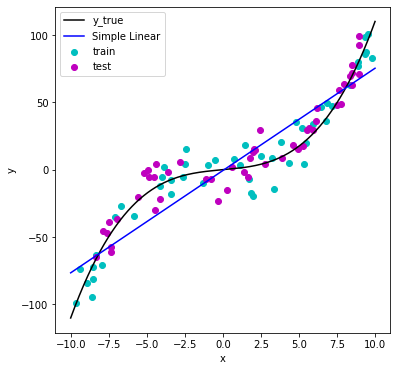

In [18]:
fig = plt.figure(figsize=(6,6))
plt.plot(X, y, color='k', label='y_true')
plt.scatter(X_train, y_train, color='c', label='train')
plt.scatter(X_test, y_test, color='m', label='test')

plt.plot(X, y_hat_simple, color='b', label='Simple Linear')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Modify Input Features
Perhaps the information available to the simple linear regression model is not enough to capture the true nature of the phenomenon we are estimating. 

There may be additional features that can be, or have been measured that could provide additional information to our model. For example, say you would like to estimate a car's top speed. You could use a single feature such as the weight of the car to train a model, but that might not be sufficient information. In this case you would probably want to to use additional features such as torque, power etc. You should also be aware that some features might not offer valuable information. Having more features increases the complexity of the model which could help decrease bias, but having too many may lead to high variance, resulting in the model overfitting. 

We could also perform feature engineering to acquire additonal information from the features we already have. A common method for extending our linear assumption is to introduce polynomial features. In this example we of course know the true function is a polynomial, but in general we would not know this information beforehand. 

Sklearn provides a useful function for automating this process, but it is trivial to implement. All that is happening in this example is we are creating a new set of features from our original, single feature.

\begin{align}
x \rightarrow \begin{bmatrix}
x \\
x^2 \\
x^3 \\
\vdots \\
x^m
\end{bmatrix}
\end{align}

We can create any number of features, but again we should be aware that increasing the dimensionality too much may result in overfitting.

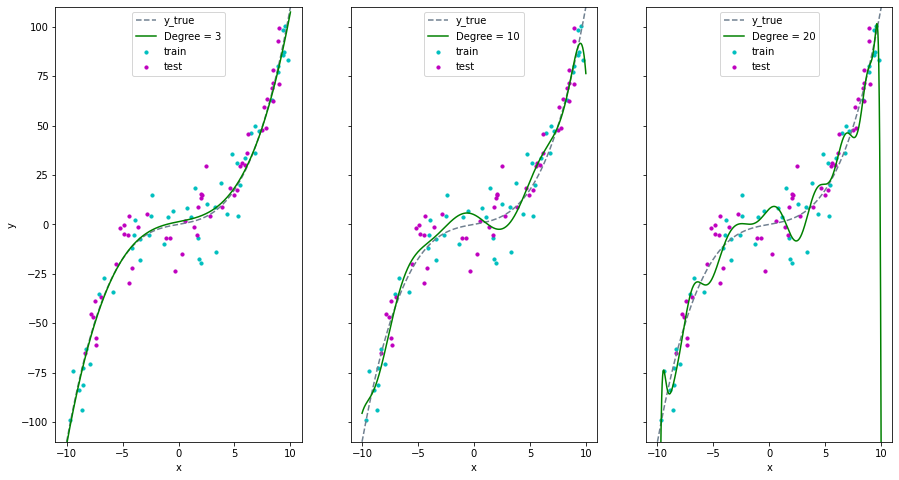

In [19]:
fig, axes = plt.subplots(1, 3,figsize=(15,8), sharey=True)
coefs = {}
for i, degree in enumerate([3, 10, 20]):
    
    axes[i].plot(X, y, color='slategrey', linestyle='--', label='y_true')
    axes[i].scatter(X_train, y_train, color='c', s=10, label='train')
    axes[i].scatter(X_test, y_test, color='m', s=10, label='test')
    
    # Generate polynomial features from training data
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_train.reshape(-1, 1))

    # Define linear model with no regularization
    poly_reg = LinearRegression(normalize=True)
    
    # Fit linear model to training data
    poly_reg.fit(X_poly, y_train)
    
    coefs['{}'.format(degree)] = poly_reg.coef_
    
    # Predict on X to generate curve
    y_hat_poly = poly_reg.predict(poly.transform(X))
    
    axes[i].plot(X, y_hat_poly, color='g', label='Degree = {}'.format(degree))
    
    axes[i].set_xlabel('x')
    axes[i].set_ylim(-110, 110)
    
    axes[i].legend(loc='upper center')
    
axes[0].set_ylabel('y')  
plt.show()    

The more features we added to the polynomial regression, the more model parameters we had. The increased flexibility allows the model to fit the data better. Intuitively a polynomial of degree 3 should work the best because that is what the true model is based on. Adding too many features results in the model fitting very well on the training data, as shown. However, the models with high degree polynomials clearly overfit and do not generalize well. 

In [20]:
for key, value in coefs.items():
    print("Degree {}:\nCoefficients\n{}\n".format(key, np.array_str(value.round(8))))

Degree 3:
Coefficients
[ 1.143852   -0.03352409  0.09796609]

Degree 10:
Coefficients
[-2.61537272e+00 -1.83365878e+00  4.35734370e-01  1.52171120e-01
 -1.07853800e-02 -4.34659000e-03  1.47690000e-04  5.02300000e-05
 -7.20000000e-07 -2.00000000e-07]

Degree 20:
Coefficients
[ 5.20787237e+00 -4.24670314e+00 -3.47043508e+00  2.74654440e-01
  5.85086670e-01  4.79129500e-02 -4.22332000e-02 -7.07632000e-03
  1.68241000e-03  3.85790000e-04 -4.02200000e-05 -1.11900000e-05
  5.90000000e-07  1.90000000e-07 -1.00000000e-08 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00]



In [9]:
from IPython.display import display, Math, Markdown
display(Markdown('For example the polynomial of degree 3 would have the following form:'))
display(Math(r'\hat{{y}} = {}x + {}x^2 + {}x^3'.format(coefs['3'][0].round(8), coefs['3'][1].round(8), coefs['3'][2].round(8))))

For example the polynomial of degree 3 would have the following form:

<IPython.core.display.Math object>

# Feature Selection
If you have a dataset that contains a large number of features, how can you choose which ones provide the most information?
One way, for linear models is to recursively eliminate features. In linear models the coefficients for a given feature indicate its impact on the prediction. Small values indicate they don't impact the response. 

With this in mind you could perform the following steps:
1. Train the model
2. Eliminate the feature that has the smallest coefficient
3. Repeat 1 - 2 until you reach a desirable number of features

This might be suitable for certain applications, but that depends if your model has a strong correlation between coefficients and features. It would also be unsuitable for models that take a long time to train, as you have to repeatedly retrain your model.

Another option to aid in reducing model complexity is regularization.

## Regularization: Constraining parameters
Using as many features as possible should produce models with low bias, as we have seen. As mentioned before, having too many features results in overfitting, but are there methods to choose the optimal features to use? 

One of the most popular techniques that can achieve something like this is called **regularization**. The general idea is to constrain the parameters (coefficients) such that they tend towards zero. This takes place in an embedded way by including an additional term to the loss function.

For linear models there are specific names given to the two most used forms of regularization: LASSO and Ridge regression. More generally you will see similar methods applied to non-linear models where the type of regularization is described by the form of the penalty term (usually an $l_1$ or $l_2$ penalty).

For Lasso regression the penalty is an $l_1$ penalty. We would add this penalty on to the objective function we are trying to minimize. For example if our original objective function was the Mean Squared Error (MSE) then we would add an additional term as follows:

$$
J(\mathbf{\theta}) = MSE + \lambda\sum_{j=1}^{m}|\theta_j|
$$

To help you visualise this, suppose there were two parameters $\theta_1$ and $\theta_2$. The penalty term would introduce a constraint when minimizing $J$: $|\theta_1| + |\theta_2| \leq C$ where C is some constant that would be determined by the choice of $\lambda$. This introduces four conditions:

\begin{align}
\theta_1 + \theta_2 &\leq C \\
-\theta_1 + -\theta_2 &\leq  C \\
-\theta_1 + \theta_2 &\leq  C \\
\theta_1 - \theta_2 &\leq  C \\
\end{align}

Plotting these on a set of axes along with the contours of the original function would produce the following

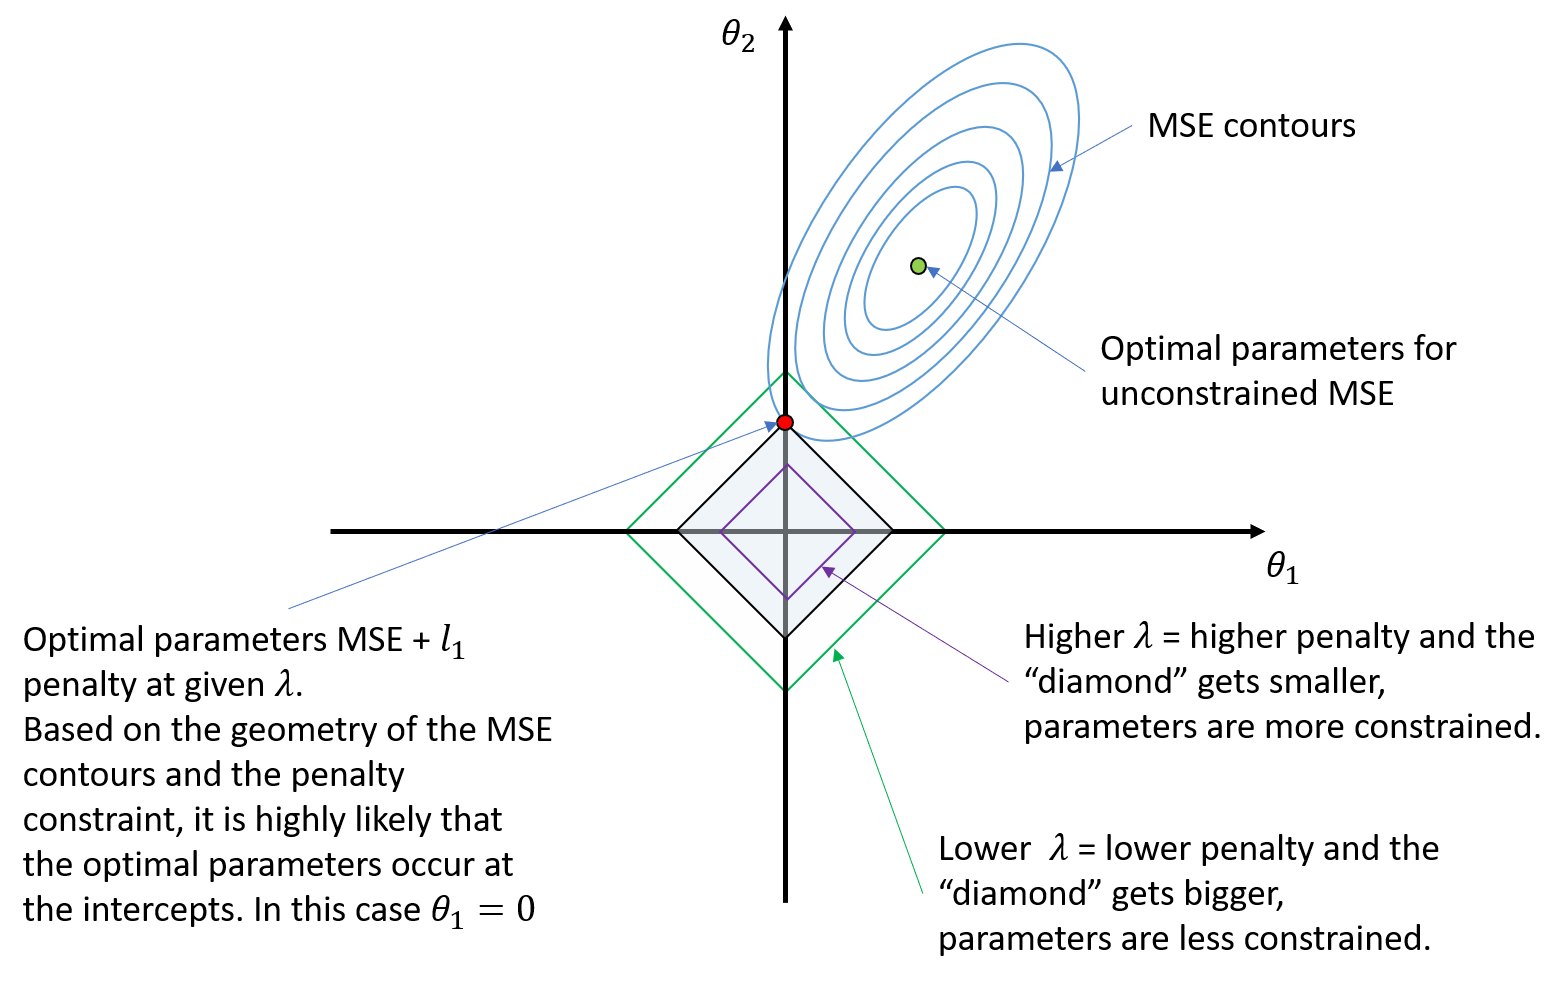

In [10]:
from IPython.display import Image
Image(filename='img/lasso.png', retina=True)

The optimal values for the parameters would be the point on the constraint that is the closest to the minimum for the original objective function. Based on the geometry of the constraint we can see that the original contours are likely to intersect the constraint boundary at the intercepts, thus resulting in values of exactly zero for one of the parameters. This results in what is a **sparse** set of parameters and thus a simpler model, which should have a lower variance and be less prone to overfitting.   

For Ridge regression the penalty is an $l_2$ penalty. As before we would add an additional term as follows:

$$
J(\mathbf{\theta}) = MSE + \lambda\sum_{j=1}^{m}\theta_j^2
$$

Once again we can try visualise this with two parameters. In this case the constraint would be $\theta_1^2 + \theta_2^2 \leq C$, which would plot a circle as shown:


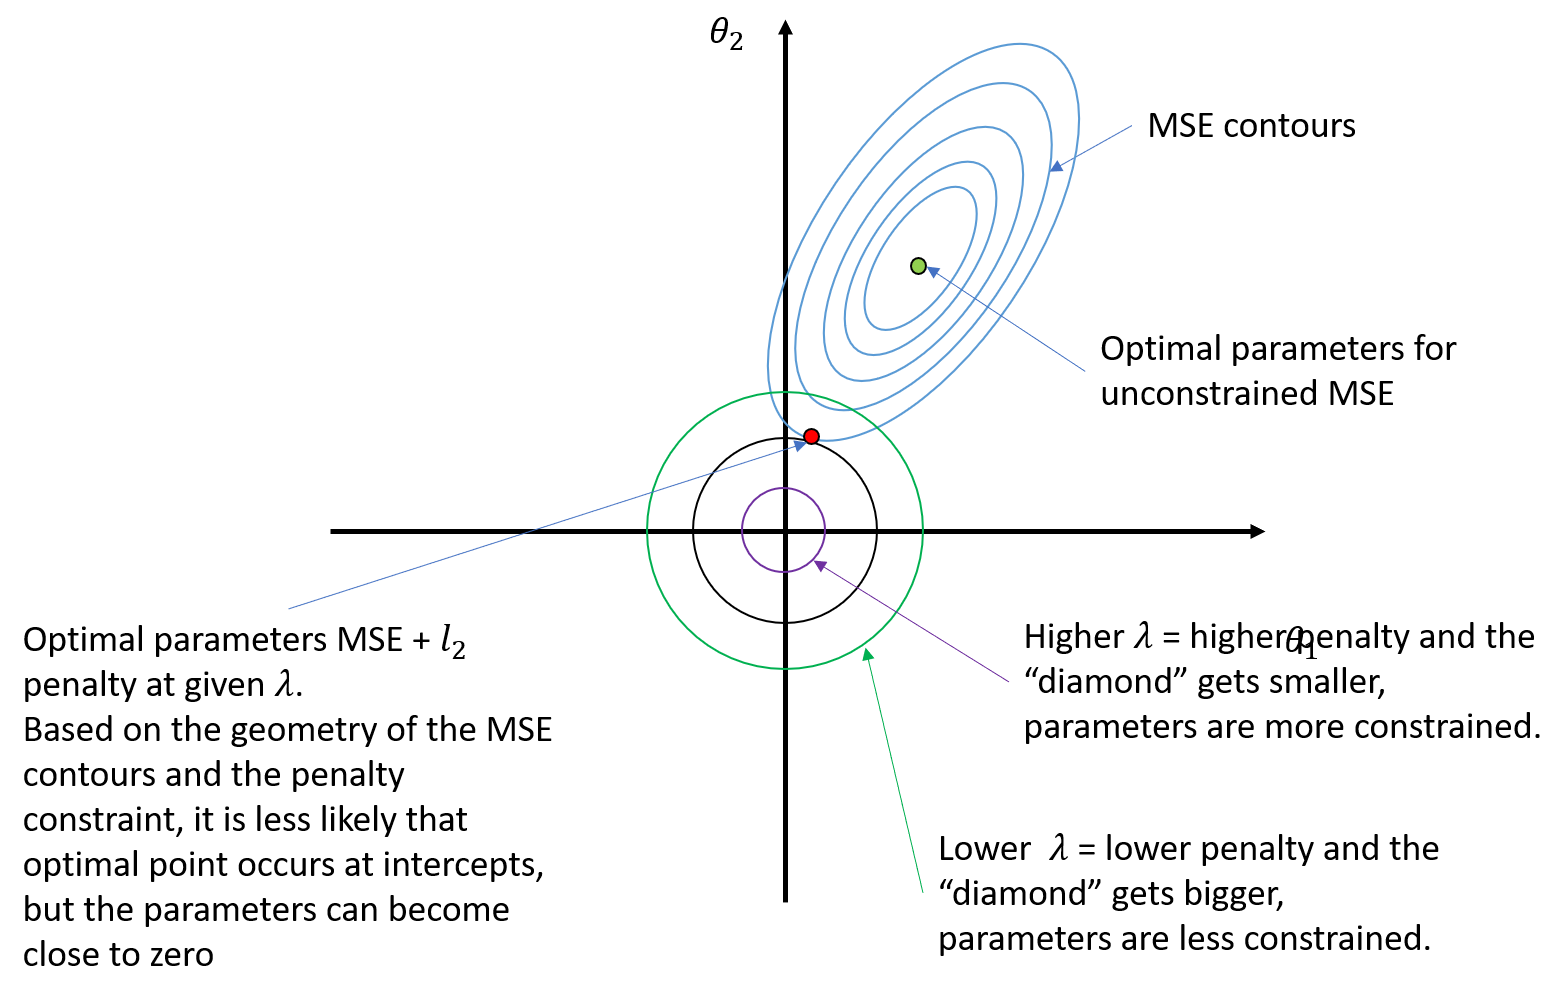

In [11]:
from IPython.display import Image
Image(filename='img/ridge.png', retina=True)

Ridge regression also produces small parameters, however, they are less likely to be exactly equaly to zero compared to Lasso regression. Instead of completely disregarding a number of features (which may increase bias, as the model capacity decreases) they are kept, but their impact is reduced due to the constraint that causes the coefficients to be small.

In [21]:
poly = PolynomialFeatures(degree=25, include_bias=False)
X_poly = poly.fit_transform(X_train.reshape(-1, 1))

In [22]:
# Define linear models with regularization
l1_reg = Lasso(alpha=0.1, max_iter=10000, normalize=True)
l2_reg = Ridge(alpha=0.1, max_iter=10000, normalize=True)

In [23]:
# Fit Linear, Lasso, Ridge Regressors on training data with polynomial features
l1_reg.fit(X_poly, y_train)
l2_reg.fit(X_poly, y_train)

Ridge(alpha=0.1, max_iter=10000, normalize=True)

In [24]:
# Predict for all values of X to generate curves 
y_hat_l1 = l1_reg.predict(poly.transform(X))
y_hat_l2 = l2_reg.predict(poly.transform(X))

In [25]:
poly_reg.fit(X_poly, y_train)
# Predict on X to generate curve
y_hat_poly = poly_reg.predict(poly.transform(X))

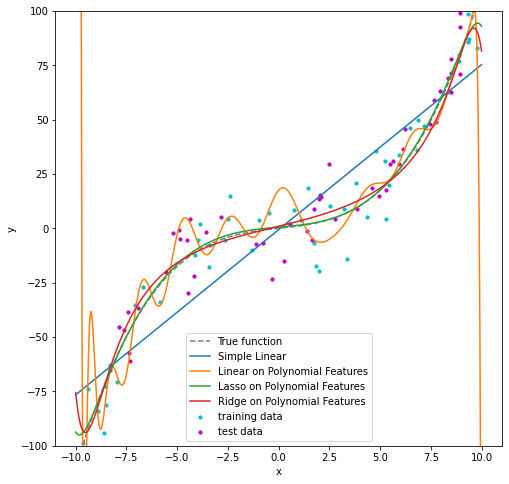

In [26]:
fig = plt.figure(figsize=(8,8))

# Plot ground truth data
plt.plot(X, y, label='True function', color='slategrey', linestyle='--')
plt.scatter(X_train, y_train, s=10, color='c', label='training data')
plt.scatter(X_test, y_test, s=10, color='m', label='test data')

# Plot predicted regression curves
plt.plot(X, y_hat_simple,label='Simple Linear')
plt.plot(X, y_hat_poly, label='Linear on Polynomial Features')
plt.plot(X, y_hat_l1, label='Lasso on Polynomial Features')
plt.plot(X, y_hat_l2, label='Ridge on Polynomial Features')

plt.ylim(-100, 100)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Even though the Lasso and Ridge regressors were fit on data that had 25 features the predicted curves are smooth and appear to fit the test data just as well as the training data. Seeing as we have access to the true function we can clearly see that they both fit well. 

To dig a bit deeper let's look at what happened to the various coefficients:

In [27]:
np.set_printoptions(precision=12, suppress=True)
print("Linear Coefficients: \n{}".format(poly_reg.coef_))
print("Lasso (L1) Coefficients: \n{}".format(l1_reg.coef_))
print("Ridge (L2) Coefficients: \n{}".format(l2_reg.coef_))

Linear Coefficients: 
[ 10.406142461842 -22.973775738907  -6.701540410533   9.457354793872
   1.030039463359  -1.835838930532  -0.020710823496   0.194944331687
  -0.007353467799  -0.012383073406   0.000785819796   0.000499004347
  -0.000038878275  -0.000013199581   0.00000114279    0.000000232111
  -0.000000021376  -0.000000002687   0.000000000257   0.00000000002
  -0.000000000002  -0.               0.               0.
  -0.            ]
Lasso (L1) Coefficients: 
[ 0.79535351436  -0.              0.104772578829 -0.00001165499
  0.             -0.000000824902  0.             -0.
 -0.             -0.             -0.             -0.
 -0.             -0.             -0.             -0.
 -0.             -0.             -0.             -0.
 -0.             -0.             -0.             -0.
 -0.            ]
Ridge (L2) Coefficients: 
[ 2.291665470416  0.027931621569  0.035843067141 -0.000344908081
  0.000314975393 -0.000005203776  0.000002499681 -0.00000004196
  0.000000018515 -0.0000000001

The standard linear regression model has coefficients that are large which is especially problematic for the higher-order polynomial terms which results in all of the twists and turns.

The Lasso regression model has indeed produced parameters that are exactly zero, and resembles the parameters of the true function quite well.

The Ridge regression model has reduced the parameters to small values which helps minimize the effect of some of the higher-order terms, but not completely. 

For this task it should make sense that Lasso regression produced the best model because the true function only consisted of two features. The sparsity introduced by the $l_1$ regularization term allowed the model to eliminate unnecessary features by forcing their coefficients to zero.

There are many tasks do not have such simple forms, in which case $l_2$ regularization often performs better as it allows sufficently complex models while reducing tendencies of overfitting.

# Initial Evaluation of MSE
To emphasis the overfitting problems let's have a look at the MSE for the various models in both training and testing.

In [29]:
y_hat_simple = simple_reg.predict(X_train.reshape(-1, 1))
y_hat_poly = poly_reg.predict(poly.transform(X_train.reshape(-1, 1)))
y_hat_l1 = l1_reg.predict(poly.transform(X_train.reshape(-1, 1)))
y_hat_l2 = l2_reg.predict(poly.transform(X_train.reshape(-1, 1)))

print("Simple Linear Regression training MSE: {}".format(mean_squared_error(y_train, y_hat_simple)))
print("Linear Regression training MSE: {}".format(mean_squared_error(y_train, y_hat_poly)))
print("Lasso Regression training MSE: {}".format(mean_squared_error(y_train, y_hat_l1)))
print("Ridge Regression training MSE: {}".format(mean_squared_error(y_train, y_hat_l2)))

Simple Linear Regression training MSE: 352.86813721437335
Linear Regression training MSE: 63.173048948065336
Lasso Regression training MSE: 108.48881000896822
Ridge Regression training MSE: 122.15711721005117


In [20]:
y_hat_simple = simple_reg.predict(X_test.reshape(-1, 1))
y_hat_poly = poly_reg.predict(poly.transform(X_test.reshape(-1, 1)))
y_hat_l1 = l1_reg.predict(poly.transform(X_test.reshape(-1, 1)))
y_hat_l2 = l2_reg.predict(poly.transform(X_test.reshape(-1, 1)))

print("Simple Linear Regression test MSE: {}".format(mean_squared_error(y_test, y_hat_simple)))
print("Linear Regression test MSE: {}".format(mean_squared_error(y_test, y_hat_poly)))
print("Lasso Regression test MSE: {}".format(mean_squared_error(y_test, y_hat_l1)))
print("Ridge Regression test MSE: {}".format(mean_squared_error(y_test, y_hat_l2)))

Simple Linear Regression test MSE: 349.2591086977932
Linear Regression test MSE: 311040833.55483645
Lasso Regression test MSE: 120.77071547109148
Ridge Regression test MSE: 157.30177450817777


The standout model to look at would be the standard linear regression model. It produces a very low training error but exceptionally high test error. 

At this stage the rudimentary method of having a single training and separate test set might not be sufficent to determine whether or not these are good estimates of the true error. To try acquire better estimes we can look at resampling methods.